# Part 1: Baseline Setup

In [2]:
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import numpy as np
import types
import torch.optim as optim
import gc


device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pre-trained ResNet-152
resnet152 = torchvision.models.resnet152(weights="IMAGENET1K_V2")
resnet152 = resnet152.to(device)
resnet152.eval()
print("ResNet-152 loaded successfully.")


ResNet-152 loaded successfully.


In [4]:
num_classes = 10
resnet152.fc = nn.Linear(resnet152.fc.in_features, num_classes).to(device)
print("Final classification layer replaced for CIFAR-10.")


Final classification layer replaced for CIFAR-10.


In [ ]:
# Freeze all layers except final fc layer
for param in resnet152.parameters():
    param.requires_grad = False
for param in resnet152.fc.parameters():
    param.requires_grad = True


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 170M/170M [00:05<00:00, 31.4MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet152.fc.parameters(), lr=1e-3)


In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    resnet152.train()
    total_correct, total_loss = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet152(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_correct / len(train_dataset)

    # Validation
    resnet152.eval()
    val_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet152(images)
            val_correct += (outputs.argmax(1) == labels).sum().item()
    val_acc = val_correct / len(test_dataset)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")


Epoch 1: Train Acc = 0.7695, Val Acc = 0.8187
Epoch 2: Train Acc = 0.8331, Val Acc = 0.8357
Epoch 3: Train Acc = 0.8470, Val Acc = 0.8435


# Part 2: Residual Connections in Practice

In [ ]:
# Pick the block to disable skip connection
block = resnet152.layer2[0]

# Redefine forward method WITHOUT the skip connection
def forward_no_skip(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    # Skip connection removed here
    out = self.relu(out)
    return out

# Bind new forward to the block
block.forward = types.MethodType(forward_no_skip, block)

# Freeze backbone except final FC layer
for param in resnet152.parameters():
    param.requires_grad = False
for param in resnet152.fc.parameters():
    param.requires_grad = True

# Optimizer and loss
optimizer = torch.optim.Adam(resnet152.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 3
for epoch in range(num_epochs):
    resnet152.train()
    total_correct, total_loss = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet152(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()
    train_acc = total_correct / len(train_dataset)

    # Validation
    resnet152.eval()
    val_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet152(images)
            val_correct += (outputs.argmax(1) == labels).sum().item()
    val_acc = val_correct / len(test_dataset)

    print(f"Epoch {epoch+1} (No skip block): Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")


Epoch 1 (No skip block): Train Acc = 0.5875, Val Acc = 0.6060
Epoch 2 (No skip block): Train Acc = 0.6222, Val Acc = 0.6228
Epoch 3 (No skip block): Train Acc = 0.6377, Val Acc = 0.6249


# Part 3: Feature Hierarchies and Representations

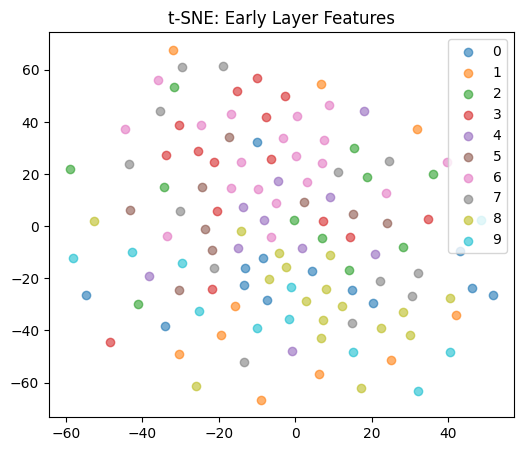

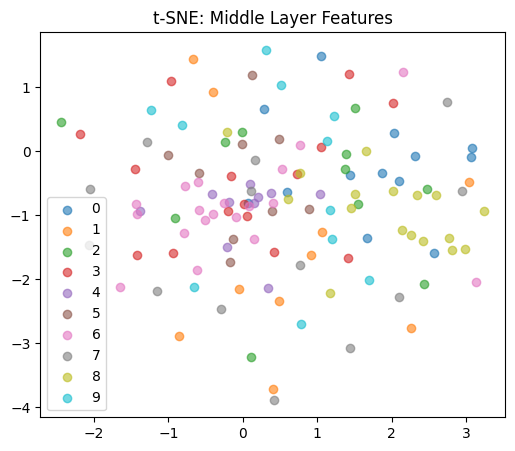

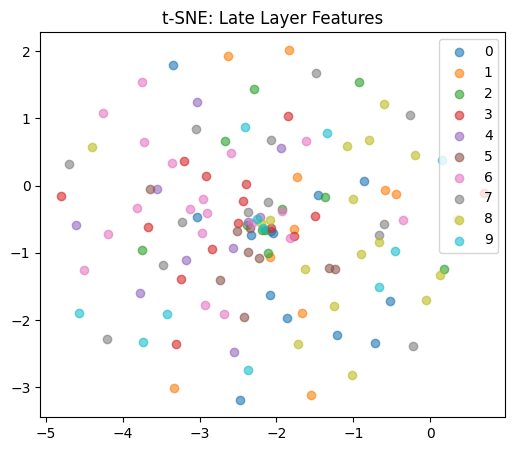

In [ ]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

resnet152.layer1[0].register_forward_hook(get_activation('early'))
resnet152.layer3[0].register_forward_hook(get_activation('middle'))
resnet152.layer4[0].register_forward_hook(get_activation('late'))

resnet152.eval()
images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    _ = resnet152(images)

labels = labels.numpy()

early_feat = activations['early'].reshape(images.size(0), -1).cpu().numpy()
middle_feat = activations['middle'].reshape(images.size(0), -1).cpu().numpy()
late_feat = activations['late'].reshape(images.size(0), -1).cpu().numpy()


def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(6,5))
    for cls in np.unique(labels):
        idxs = labels == cls
        plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], label=str(cls), alpha=0.6)
    plt.title(title)
    plt.legend()
    plt.show()


plot_tsne(early_feat, labels, "t-SNE: Early Layer Features")
plot_tsne(middle_feat, labels, "t-SNE: Middle Layer Features")
plot_tsne(late_feat, labels, "t-SNE: Late Layer Features")


**How does class separability evolve across layers? What differences can you observe between low-level and high-level representations?**

We can say that early layers capture low-level features like edges and textures, so class separability is weak. Middle layers learn shapes and parts, improving clustering but with some overlap. Late layers capture high-level, class-specific features, making classes clearly separable. In short, representations evolve from generic to highly discriminative as we go deeper.

# Part 4. Transfer Learning and Generalization

In [ ]:
num_classes = 10
batch_size = 16
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.CrossEntropyLoss()


def train_model(model, optimizer):
    for epoch in range(epochs):
        model.train()
        correct = 0

        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_set)

        model.eval()
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = model(images)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_set)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


torch.cuda.empty_cache()

model = models.resnet152(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

for p in model.parameters():
    p.requires_grad = False
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

print("\nPretrained ResNet-152 – Last Block Fine-Tuning")
train_model(model, optimizer)

del model, optimizer
gc.collect()
torch.cuda.empty_cache()


model = models.resnet152(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

for p in model.parameters():
    p.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("\nPretrained ResNet-152 – Full Fine-Tuning")
train_model(model, optimizer)

del model, optimizer
gc.collect()
torch.cuda.empty_cache()


model = models.resnet152(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("\nResNet-152 – Training from Scratch")
train_model(model, optimizer)



Pretrained ResNet-152 – Last Block Fine-Tuning
Epoch 1: Train Acc=0.8578, Val Acc=0.9072
Epoch 2: Train Acc=0.9234, Val Acc=0.9175
Epoch 3: Train Acc=0.9506, Val Acc=0.9193

Pretrained ResNet-152 – Full Fine-Tuning
Epoch 1: Train Acc=0.9147, Val Acc=0.9528
Epoch 2: Train Acc=0.9643, Val Acc=0.9619
Epoch 3: Train Acc=0.9746, Val Acc=0.9540

ResNet-152 – Training from Scratch
Epoch 1: Train Acc=0.3265, Val Acc=0.4377
Epoch 2: Train Acc=0.5255, Val Acc=0.6472
Epoch 3: Train Acc=0.6661, Val Acc=0.6887


**Which setting provides the best trade-off between compute and accuracy? Which layers seem most transferable across datasets, and why?**

We can say that fine-tuning only the final block of a pretrained ResNet-152 offers the best trade-off between compute and accuracy, training faster while still performing well. Early and middle layers are the most transferable, capturing generic features like edges and textures, while later layers are task-specific and should be fine-tuned to adapt to new datasets. In short, freeze early layers and fine-tune later ones for efficiency, or fine-tune the full network if maximum accuracy is needed.